# First Order LFM

In this note we describe some of the basic functionality of the latent force model, LFM. In this note we will treat the parameters as being known and fixed, and instead discuss the joint distributional properties of the trajectories and latent forces. 

The process of model fitting and learning of the structural parameters will be described in a seperate notebook. Before starting we make the following imports.

In [1]:
%matplotlib inline
#matplotlib.rcParams['figure.dpi']= 150

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import tensorflow as tf
from lfm_flow.kernels import LFM1_RBF
from lfm_flow.latentforcemodels import LLFM

np.random.seed(123)
np.set_printoptions(precision=3, suppress=True)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Introduction

The first order LFM describes the time-evolution of a system of trajectories $x_p(t)$ for $p=1,\ldots, K$, by a system of inhomogenous first order linear ODEs

$$
\dot{x}(t) - D_p x(t) = f_p(t), \qquad p=1,\ldots, K,
$$

where the forcing function $f_p(t)$ is itself given by a linear combination of a set of independent Gaussian process

$$
f_p(t) = \sum_{r=1}^R S_{pr} g_r(t), \qquad g_r(t) \sim \mathcal{GP}(0, k_r(\cdot, \cdot)).
$$

This system has a solution

$$
x_p(t) = e^{D_p t}x_p(0) + \int_0^{t} e^{D_p(t-\tau)} f_p(\tau)d\tau,
$$

this pathwise solution represents the trajectories as a linear transformation of the underlying Gaussian latent forces, and it is this fact that makes the LFM a tractable model for inference.

In this block below we demonstrate how to simulate from a model of this type using a numerical ODE routine with known forces

An important feature of the GP models is there ability to collect data from multioutputs at irregularly space time points, and to make inferences when we only observe some of the trajectories. Then when we come to make our training data we shall

* collect `N1 = 20` observations from $x_1(t)$
* collect `N2 = 0` observations from $x_2(t)$
* collect `N3 = 14` observations from $x_3(t)$

with this specification the entire sample path of $x_2(t)$ is unobserved.

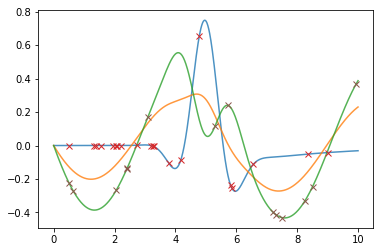

In [2]:
S = np.array([[0., 2.],
              [-0.3, 0.2],
              [-0.5,-1.0]])
D = np.array([.3, 0.5, 0.3])

# "True" latent forces
g1 = lambda t: np.cos(t)
g2 = lambda t: np.exp(-(t-5.)**2)*np.sin(np.pi*t)

# Dense set of time points to solve the model on
ttd = np.linspace(0., 10., 1000)

# Time-Evolution equation
def dXdt(X, t):
    # equivalent to diag(-D).dot(X) + S.dot(g)
    g = np.array([g1(t), g2(t)])
    return -D * X + S.dot(g)

# numerically solve the ODE
sol = odeint(dXdt, [0., 0., 0.], ttd)

# make our training data
N1, N2, N3 = [20, 0, 14]
inds = [np.random.choice(ttd.size-1,
                         replace=False,
                         size=N)
        for N in [N1, N2, N3]]

t1, t2, t3 = [ttd[ind] for ind in inds]
X1, X2, X3 = [sol[ind, i] for i, ind in enumerate(inds)]

fig, ax = plt.subplots()
ax.plot(ttd, sol, alpha=0.8)
for t, x in zip([t1, t2, t3], [X1, X2, X3]):
    ax.plot(t, x, 'x')
plt.show()

Note that since 

$$
S_{1,:} = \begin{bmatrix} 0. & 2. \end{bmatrix}
$$

the dynamics of $x_{1}(t)$ are driven entirely by the first latent force, $g_1(t)$. Since this force is quiesencent for the first part of the interval this trajectory remains constant at its steady state initial condition until the force grows sufficient to cause motion in $x_1(t)$, after which it begins to return towards its resting value.

### Tensor flow session

To take advantage of the automatic differentiation, and to better slot the LFM into more complex models we have built on top of the `TensorFlow` package. In the next code block we use the function in `googlecolab` to close any existing TensorFlow sessions and start a new one

In [3]:
import warnings

def reset_session():
    """Creates a new global, interactive session in Graph-mode."""
    global sess
    try:
        tf.reset_default_graph()
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession()
reset_session()

## Multioutputs Kernel

With the basic imports taken care of we now taken the opportunity to discuss the structure of the kernel in more detail. 

At any given time point the MLFM model takes the form of a $K$-dimensional Gaussian random variable, and so is a particular instance of the more general multioutput regression model. In this case the feature space is given by

$$
\underbrace{\mathbb{R}^{1} \times \cdots \times \mathbb{R}^{1}}_{K \mbox{ times}}
$$

The typical observations of a given trajectory, $x_k(t)$, will have shape `[b1,...,bB, Nk, 1]` with `N_k = 0` if we have no observations from this output. 

The `MultioutputKernel` object itself will return a (batch) of covariance matrices of shape `[b1,...,bB, sum(N1 + ... + Nk), 1]`. To ensure that the `MultioutputKernel` behaves like a regular kernel we only ever pass a flattened version of the input

(*note* this requires that all the input points have the same batched shape)

In [4]:
reset_session()
lf_length_scales = [.15, .15]
kern = LFM1_RBF(D, S, lf_length_scales)

# placeholders tensors for observed time-points
t1_t = tf.placeholder(np.float64, shape=(N1, 1))
t2_t = tf.placeholder(np.float64, shape=(N2, 1))
t3_t = tf.placeholder(np.float64, shape=(N3, 1))

tt = tf.concat([t1_t, t2_t, t3_t], axis=-2)

Kyy = kern._apply(tt, x1_shape=[N1, N2, N3])

sess.run(tf.global_variables_initializer())

eigvals = tf.linalg.eigvalsh(Kyy)
Kyy = sess.run(eigvals, 
               feed_dict={t1_t: t1[:, None], 
                          t2_t: t2[:, None],
                          t3_t: t3[:, None]})

Instructions for updating:
Colocations handled automatically by placer.


### The `LFM` Class

Having described the kernel of the LFM we now want to incorporate in a more general class which behaves like the `GaussianProcess` class in TensorFlowProbability, but also takes care of handing the input points.

In [6]:
#
index_points = [t1_t, t2_t, t3_t]

# 
index_nshape = [N1, N2, N3] 

#val = [item.shape for item in index_points]
#Kyy = kern._apply(tt, x1_shape=val)
#print(val)
#lfm = LLFM(kern, [t1_t, t2_t, t3_t])
#print(lfm._orig_index_points)

The result is an $N \times N$ array where the total size is given by `N = N1 + N2 + N3`. The upper $N_1 \times N_1$ sublock gives the covariance matrix of $x_1(t)$ at `t1`. Similarly the lower $N_3 \times N_3$ submatrix gives the covariance of $x_3(t)$ evaluated on the vector `t3`. 

Because we input an empty array we have no observations from $x_2$, and it doesn't appear in the evaluated kernel matrix.

### Analytic test

We have

$$
\mathrm{cov}\{y_p(t), y_q(t') \} = 
\sum_{r=1}^R
S_{pr}S_{qr}\int_0^t \int_0^{t'}
e^{-D_p(t-\tau)}e^{-D_q(t'-\tau')}
k_{r}(\tau - \tau') d\tau d\tau',
$$

an inefficient implementation of this is given below

In [ ]:
from scipy.integrate import dblquad

lf_length_scales = sess.run(kern.lf_length_scales)
def numint_quad(t, t2, p, q):
    """
    Returns the covariance of y_p(t) and yq(t2)
    """
    def integrand(y, x, r):
        ep = np.exp(-D[p]*(t-x))
        eq = np.exp(-D[q]*(t2-y))
        return ep*eq*np.exp(-(x-y)**2/lf_length_scales[r]**2)
    k = 0.
    for r in range(2):
        I, err = dblquad(integrand, 
                         0., t,
                         lambda x: 0., lambda x: t2, 
                         args=(r, ))
        k += I * S[p, r] * S[q, r]
    return k

t1 = np.array([0.3, 1.5, 2.5])
i = 0
j = 1
k = numint_quad(t1[i], t1[j], 0, 0)    

_K11 = np.zeros((3, 3))
for i, t1_i in enumerate(t1):
    for j, t1_j in enumerate(t1):
        _K11[i, j] = numint_quad(t1_i, t1_j, 0, 0)

_K13 = np.zeros((3, 2))
for i, t_i in enumerate(t1):
    for j, t_j in enumerate(t3):
        _K13[i, j] = numint_quad(t_i, t_j, 0, 2)
        
print(_K11)
print(Kyy[:3, :3])

print(_K13)
print(Kyy[:3, 3:])

In [ ]:

tt = [t1, t2, t3]

ttpred = [np.array([]),
          np.linspace(0., 3., 7),
          np.array([])]

Kyypred = kern(tt, ttpred)
Kyypred = sess.run(Kyypred)
Lyy = tf.linalg.cholesky(Kyy)
K21 = tf.transpose(Kyypred, (1, 0))

Y = tf.placeholder(name='Y', shape=(5, 1), dtype=np.float64)

mf = tf.matmul(K21, 
                tf.linalg.cholesky_solve(Lyy, Y))

### Prediction

Having discussed the structure of the multiouput kernel underlying the MLFM, and checked the implementation using numerical quadrature, we now consider how to predict the trajectories on the basis of observations.

In [ ]:
# make our training data
N1, N2, N3 = [20, 0, 14]
inds = [np.random.choice(ttd.size-1,
                         replace=False,
                         size=N)
        for N in [N1, N2, N3]]

t1, t2, t3 = [ttd[ind] for ind in inds]
X1, X2, X3 = [sol[ind, i] for i, ind in enumerate(inds)]

Y = tf.placeholder(name='Y', 
                   shape=(N1 + N2 + N3, 1), 
                   dtype=np.float64)

lfm = LLFM(kern)
lfm.t_input = [t1, t2, t3]
lfm.Y = Y

# points to predict at 
ttnew = np.linspace(ttd[0], ttd[-1], 1000)

my = lfm.predict([ttnew]*3)

val = np.hstack([X1, X2, X3])
val = val[:, None]

my, Cy = sess.run(my, feed_dict={Y: val})
my = my.reshape(3, 1000)

marg_var = np.diag(Cy)
marg_std = np.sqrt(marg_var)
marg_std = marg_std.reshape(3, ttnew.size)

In [ ]:
# plots!
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(12, 5)

for k, (x, ax) in enumerate(zip(sol.T, (ax1, ax2, ax3))):
    ax.plot(ttd, x, 'k-', alpha=0.8,
            label=r'$y_{}(t)$'.format(k))
    ax.set_xlabel('time')
    
for k, (xp, ax) in enumerate(zip(my, (ax1, ax2, ax3))):
    #ax.plot(ttnew, xp, '-.')
    ax.fill_between(ttnew, 
                    xp - 2*marg_std[k, :],
                    xp + 2*marg_std[k, :], alpha=0.3)
    ax.plot(ttnew, xp, '-.', 
            label=r'$E_{}[y_{}(t) | y]$'.format(k,k))
    

ax1.plot(t1, X1, 'x')
ax2.plot(t2, X2, 'x')
ax3.plot(t3, X3, 'x')

ax1.legend(loc=3)
ax2.legend(loc=3)
ax3.legend(loc=3)

plt.show()